In [275]:
import pandas as pd
import numpy as np 
from datetime import datetime 
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [2]:
# Loading the data and checking no. of Observations and variables 
df = pd.read_excel('TurnoverExercise.xlsx')
print(df.shape)
df.head()

(5000, 12)


,workerID,gender,race,department,location,jobType,birth,hired,performance,salary,bonusAmount,voluntaryTermination
0,101,M,Black or African American,IT,Boise,Engineer 4,1989-08-07,2009-01-31,3.0,148300,3300.0,0
1,144,M,White,Back End,Honolulu,Manager 3,1987-11-23,2011-03-06,2.0,155976,3200.0,0
2,158,M,White,Back End,Boise,Engineer 2,1997-10-29,2017-04-15,NaN,117592,2600.0,0
3,197,M,White,R&D,Honolulu,Professional 3,1990-06-22,2013-12-27,4.0,122195,4200.0,0
4,248,M,Asian,IT,Rome,Professional 3,1983-09-09,2002-10-28,2.0,83449,1100.0,0


In [7]:
# Checking 
df.dtypes

workerID                         int64
gender                          object
race                            object
department                      object
location                        object
jobType                         object
birth                   datetime64[ns]
hired                   datetime64[ns]
performance                    float64
salary                           int64
bonusAmount                    float64
voluntaryTermination             int64
dtype: object

## PART I: DATA INSPECTION

### Q1

In [3]:
start = datetime.strptime('2000-01-01','%Y-%m-%d' )
end = datetime.strptime('2011-01-01','%Y-%m-%d' )
q1 = df[(df.hired >= start) & (df.hired < end)]
print(min(q1.hired))
print(max(q1.hired))
print('Table size:'+str(q1.shape))
print('Count of Hired Workers from 2000 to 2010:' + str(len(q1.workerID.unique())))
print('Average Salary:$'+str(round(np.mean(q1.salary),2)))

2000-01-01 00:00:00
2010-12-29 00:00:00
Table size:(2681, 12)
Count of Hired Workers from 2000 to 2010:2681
Average Salary:$107817.38


### Q2

In [272]:
print(df.location.unique())
df['present_date'] = datetime.strptime('2018-01-31','%Y-%m-%d' )
df['age_q2'] = [(df.loc[i,'present_date'] - df.loc[i,'birth']).days/365.25 for i in range(len(df))]
print('Max Age: '+str(max(df.age)))
print('Min Age: '+str(min(df.age)))
print('Quantiles of Age:')
print(df.age.quantile([0,0.25,0.5,0.75,0.90,0.95,0.99]))
df.head()

['Boise' 'Honolulu' 'Rome' 'Singapore' 'Paris' 'Las Vegas' 'Vulcan']
Max Age: 118.078028747
Min Age: 17.7577002053
Quantiles of Age:
0.00    17.757700
0.25    32.886379
0.50    39.709788
0.75    46.449008
0.90    52.873648
0.95    56.799726
0.99    69.722108
Name: age, dtype: float64


,workerID,gender,race,department,location,jobType,birth,hired,performance,salary,bonusAmount,voluntaryTermination,present_date,age,tenure,now_date,age_q2
0,101,M,Black or African American,IT,Boise,Engineer 4,1989-08-07,2009-01-31,3.0,148300,3300.0,0,2018-01-31,28.484600,9.289528,2018-05-17 11:34:51.145032,28.484600
1,144,M,White,Back End,Honolulu,Manager 3,1987-11-23,2011-03-06,2.0,155976,3200.0,0,2018-01-31,30.190281,7.197810,2018-05-17 11:34:51.145032,30.190281
2,158,M,White,Back End,Boise,Engineer 2,1997-10-29,2017-04-15,0.0,117592,2600.0,0,2018-01-31,20.257358,1.086927,2018-05-17 11:34:51.145032,20.257358
3,197,M,White,R&D,Honolulu,Professional 3,1990-06-22,2013-12-27,4.0,122195,4200.0,0,2018-01-31,27.611225,4.386037,2018-05-17 11:34:51.145032,27.611225
4,248,M,Asian,IT,Rome,Professional 3,1983-09-09,2002-10-28,2.0,83449,1100.0,0,2018-01-31,34.395619,15.550992,2018-05-17 11:34:51.145032,34.395619


In [273]:
q2 = df[df.location == "Singapore"]
print('Table size of Singapore employees :'+str(q2.shape))
q2_age = q2[(q2.age_q2 >= 40) & (q2.jobType.str.contains('Engineer'))]
print('No. of Engineers with age >=40 in Singapore as of January 2018: '+str(len(q2_age.workerID)))
q2_active = q2_age[q2_age.voluntaryTermination == 0]
print('No. of Engineers with age >=40 who are still active in Singapore as of Jan 2018: '+str(len(q2_active.workerID)))

Table size of Singapore employees :(968, 17)
No. of Engineers with age >=40 in Singapore as of January 2018: 72
No. of Engineers with age >=40 who are still active in Singapore as of Jan 2018: 66


### Q3

In [6]:
women = df[(df.gender == "F") & (df.jobType.str.contains('Technician') )]
men = df[(df.gender == "M") & (df.jobType.str.contains('Technician') )]
women_avg_salary = women.salary.mean()
men_avg_salary = men.salary.mean()
print(women_avg_salary)
print(men_avg_salary)

65667.57918552036
83446.11467116358


In [7]:
# Independent 2 sample 2-tailed t-test 
stats.ttest_ind(women.salary,men.salary)

Ttest_indResult(statistic=-8.0374615216638272, pvalue=3.2287817378472732e-15)

#### From independent 2 sample t-test (assuming normality) we see that the difference between the salary of men and women technicians' salary is significant as p-value of the test is << 0.05 , thus rejecting the null hypothesis [ difference = 0]

### Q4

In [8]:

lis = sorted(df.performance.unique())
dic={}
for i in range(1,len(lis)):
    name = "perf"+str(i) 
    dic[name]= df[df.performance == lis[i]]


# plt.show()

In [9]:
# Checking distribution of overall performance
df.performance.value_counts()

3.0    2197
4.0    1203
2.0     869
1.0     312
5.0     271
Name: performance, dtype: int64

In [10]:
df.department.value_counts()

Back End      1253
Front End     1226
R&D            652
IT             649
HR             530
Finance        404
Purchasing     286
Name: department, dtype: int64

In [11]:
df.performance = df.performance.fillna(0)        # Replacing NaN in performance to 0
perf = df.groupby(['department','performance']).size()
dep = df.groupby('department').size()
dist = pd.DataFrame(perf.div(dep)*100)
dist.reset_index(inplace = True)
dist = dist.rename(columns={0:'Distribution'})

In [21]:
lis = sorted(df.performance.unique())
dic={}
for i in range(1,len(lis)):
    name = "perf"+str(i) 
    dic[name]= dist[dist.performance == lis[i]]

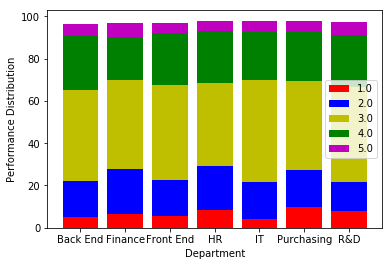

In [22]:
dep = list(dic['perf1']['department'])
ind = range(len(dep))
d1 = np.array(dic['perf1']['Distribution'])
d2 = np.array(dic['perf2']['Distribution'])
d3 = np.array(dic['perf3']['Distribution'])
d4 = np.array(dic['perf4']['Distribution'])
d5 = np.array(dic['perf5']['Distribution'])
p1 = plt.bar(ind,dic['perf1']['Distribution'],color = 'r')
p2 = plt.bar(ind,dic['perf2']['Distribution'],bottom = d1,color = 'b')
p3 = plt.bar(ind,dic['perf3']['Distribution'],bottom = d1+d2,color = 'y')
p4 = plt.bar(ind,dic['perf4']['Distribution'],bottom = d1+d2+d3,color = 'g')
p5 = plt.bar(ind,dic['perf5']['Distribution'],bottom = d1+d2+d3+d4,color = 'm')
plt.xticks(ind,dep)
plt.xlabel("Department")
plt.ylabel("Performance Distribution")
plt.legend((p1[0], p2[0], p3[0], p4[0],p5[0]),(lis[1],lis[2],lis[3],lis[4],lis[5]))
plt.show()

### Q5

Size of Filtered Table: (1391, 14)


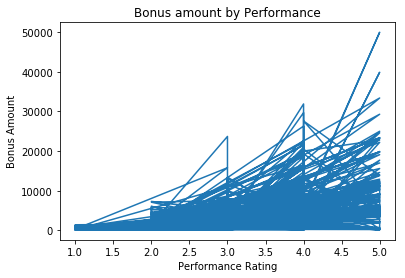

Average bonus Amount by Performance Rating


,performance,bonusAmount
0,1.0,478.378378
1,2.0,1191.666667
2,3.0,2341.891892
3,4.0,5114.921466
4,5.0,10063.333333


In [23]:
q5 = df[(df.location == "Boise") & (df.voluntaryTermination == 0) & (df.bonusAmount > 0) & (df.performance > 0)]
print('Size of Filtered Table: '+str(q5.shape))
q5_tab = pd.DataFrame(q5.groupby('performance').agg({'bonusAmount':'mean'}))
q5_tab.reset_index(inplace = True)
#plt.plot(q5_tab.performance,q5_tab.bonusAmount)
plt.plot(q5.performance,q5.bonusAmount)
plt.xlabel('Performance Rating')
plt.ylabel('Bonus Amount')
plt.title('Bonus amount by Performance')
plt.show()
print("Average bonus Amount by Performance Rating")
q5_tab

In [24]:
q5['cube_perf'] = (q5.performance) ** 3
X = q5[['performance','cube_perf']]
q5_model = sm.OLS(q5.bonusAmount,X)
q5_result = q5_model.fit()
print(q5_result.summary())

                            OLS Regression Results                            
Dep. Variable:            bonusAmount   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     806.8
Date:                Thu, 17 May 2018   Prob (F-statistic):          3.08e-233
Time:                        07:04:54   Log-Likelihood:                -13431.
No. Observations:                1391   AIC:                         2.687e+04
Df Residuals:                    1389   BIC:                         2.688e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
performance   144.7919     77.630      1.865      

C:\Users\lekha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


C:\Users\lekha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


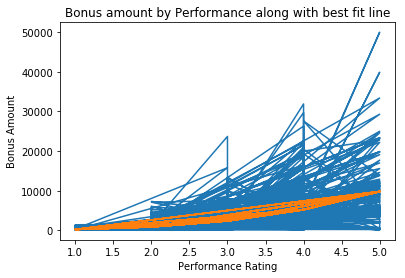

In [25]:
q5['fit_values'] = q5_result.fittedvalues
plt.plot(q5.performance,q5.bonusAmount)
plt.plot(q5.performance,q5.fit_values)
plt.xlabel('Performance Rating')
plt.ylabel('Bonus Amount')
plt.title('Bonus amount by Performance along with best fit line')
plt.show()

In [26]:
RMSE = np.sqrt(np.sum((q5.fit_values - q5.bonusAmount)**2))
print("RMSE: "+str(round(RMSE)))

RMSE: 140827.0


#### Metrics of Fit:
#### Adjusted R-Squared - 0.537
#### RMSE - 140,827
#### BIC - 2.688e+04

#### The best fit line had the above metrics and the F-square p-value shows that the performance rating and cubed_performance has a significant effect on the bonus Amount

### PART II: MODELING VOLUNTARY TURNOVER

### Q1

In [27]:
df['tenure'] = [(df.loc[i,'present_date'] - df.loc[i,'hired']).days/365.25 for i in range(len(df))]


In [28]:
# Analysis of Tenure
print('Max Tenure: '+str(max(df.tenure)))
print('Min Tenure: '+str(min(df.tenure)))
print('Quantiles of Tenure:')
print(df.tenure.quantile([0,0.10,0.2,0.25,0.3,0.5,0.75,0.8,0.90,0.95,0.99]))

Max Tenure: 52.0136892539
Min Tenure: 0.0602327173169
Quantiles of Tenure:
0.00     0.060233
0.10     4.231075
0.20     6.575222
0.25     7.588638
0.30     8.530322
0.50    12.340862
0.75    17.631759
0.80    19.048323
0.90    23.079808
0.95    27.171800
0.99    34.990171
Name: tenure, dtype: float64


In [269]:
# Removing employees with Age > 100
df['now_date'] = datetime.now()
df['age'] = [(df.loc[i,'present_date'] - df.loc[i,'birth']).days/365.25 for i in range(len(df))]
q1_2 = df[df.age<100]

# Removing Observations with tenure > min tenure and salary = 0
q1_2 = df[~((df.tenure > min(df.tenure)) & (df.salary == 0))]

print('Table Size: ' + str(q1_2.shape))

Table Size: (4954, 16)


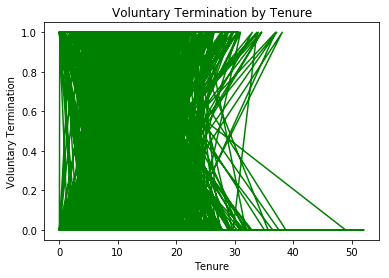

In [30]:
plt.plot(q1_2.tenure,q1_2.voluntaryTermination,color = 'g')
plt.xlabel('Tenure')
plt.ylabel('Voluntary Termination')
plt.title('Voluntary Termination by Tenure')
plt.show()

In [129]:
q1_2['tenure_transform'] = np.sqrt(q1_2.tenure)
X = q1_2[['tenure_transform','tenure']]
q1_2_model = sm.OLS(q1_2.voluntaryTermination,X)
q1_2_result = q1_2_model.fit()
print(q1_2_result.summary())

                             OLS Regression Results                             
Dep. Variable:     voluntaryTermination   R-squared:                       0.091
Model:                              OLS   Adj. R-squared:                  0.090
Method:                   Least Squares   F-statistic:                     247.2
Date:                  Thu, 17 May 2018   Prob (F-statistic):          4.72e-103
Time:                          09:12:33   Log-Likelihood:                -949.27
No. Observations:                  4954   AIC:                             1903.
Df Residuals:                      4952   BIC:                             1916.
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
tenure_transform    

C:\Users\lekha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Fitting Logistic Regression model for the same as the response variable is a flag variable after performing data preparation

In [88]:
q1_2.shape

(4954, 16)

In [303]:
upsample=q1_2.reset_index()
print(upsample.tenure.quantile([0,0.25,0.3,0.5,0.75,0.8,0.90,0.95,0.99]))
print(upsample.salary.quantile([0,0.25,0.3,0.5,0.75,0.8,0.90,0.95,0.99]))


0.00     0.060233
0.25     7.559890
0.30     8.508966
0.50    12.314853
0.75    17.610541
0.80    19.014921
0.90    23.055715
0.95    27.120876
0.99    35.010322
Name: tenure, dtype: float64
0.00     30000.00
0.25     69577.75
0.30     75299.40
0.50     97215.50
0.75    134757.25
0.80    147288.40
0.90    181984.30
0.95    218274.45
0.99    306980.55
Name: salary, dtype: float64


In [168]:
for i in range(len(upsample)):
    if upsample.loc[i,'tenure']<=10:
        upsample.loc[i,'tenure_bkt'] = 'lte10'
    elif (upsample.loc[i,'tenure'] > 10) & (upsample.loc[i,'tenure'] <= 20):
        upsample.loc[i,'tenure_bkt'] = 'lte20'
    else:
        upsample.loc[i,'tenure_bkt'] = 'gt20'

In [169]:
for i in range(len(upsample)):
    if upsample.loc[i,'salary']<=65000:
        upsample.loc[i,'salary_bkt'] = 'lte65K'
    elif (upsample.loc[i,'salary'] > 65000) & (upsample.loc[i,'salary'] <= 120000):
        upsample.loc[i,'salary_bkt'] = 'lte120K'
    else:
        upsample.loc[i,'salary_bkt'] = 'gt120K'


In [170]:
# One Hot Encoding
categ = upsample[['gender','race','department','location','jobType','tenure_bkt','salary_bkt']]
categ = pd.get_dummies(categ)
categ = categ[categ.columns.difference(['gender_0','race_0','department_Back End','location_Vulcan','jobType_Technician 5','salary_bkt_gt120K','tenure_bkt_gt20'])]

In [304]:
tab = pd.concat([upsample[['workerID','performance','bonusAmount','voluntaryTermination','age','tenure','salary']],categ],axis = 1)

#tab = tab.fillna(0)

In [323]:
# Predicting bonusAmount using Linear Regression
te_bonus = tab[tab.bonusAmount.isnull()]
tr_bonus = tab[tab.bonusAmount.notnull()]
model = linear_model.LinearRegression()
#model = sm.OLS()
model = model.fit(tr_bonus[tr_bonus.columns.difference(['bonusAmount'])],tr_bonus.bonusAmount)
tab.loc[tab.bonusAmount.isnull(),'bonusAmount'] = model.predict(te_bonus[te_bonus.columns.difference(['bonusAmount'])])
tab.bonusAmount.quantile([0,0.25,0.3,0.5,0.75,0.8,0.90,0.95,0.99])

0.00    -2126.703173
0.25      600.000000
0.30      800.000000
0.50     1600.000000
0.75     3295.292242
0.80     4000.000000
0.90     6200.000000
0.95     9600.000000
0.99    20047.000000
Name: bonusAmount, dtype: float64

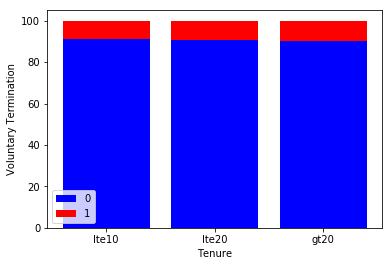

  tenure_bkt  voluntaryTermination       Dist
0       gt20                     0  91.169451
1       gt20                     1   8.830549
2      lte10                     0  90.486486
3      lte10                     1   9.513514
4      lte20                     0  90.379523
5      lte20                     1   9.620477


In [188]:
group = pd.DataFrame(upsample.groupby(['tenure_bkt','voluntaryTermination']).size())
tenure = pd.DataFrame(upsample.groupby('tenure_bkt').size())
group = pd.DataFrame(group.div(tenure)*100).reset_index()
group = group.rename(columns = {0:'Dist'})
term = np.array(group.loc[group.voluntaryTermination == 0,'Dist'])
act =  np.array(group.loc[group.voluntaryTermination == 1,'Dist'])
index = list(upsample['tenure_bkt'].unique())
y_axis = list(upsample['voluntaryTermination'].unique())
plot1 = plt.bar(range(len(index)),term,color = 'b')
plot2 = plt.bar(range(len(index)),act,color = 'r',bottom = term)
plt.xticks(range(len(index)),index)
plt.xlabel("Tenure")
plt.ylabel("Voluntary Termination")
plt.legend((plot1[0], plot2[0]),(y_axis[0],y_axis[1]))
plt.show()
print(group)

#### We see from the graph that the tenure does not have a significant effect on voluntary termination

In [189]:
tab1 = tab[['tenure_bkt_lte10','tenure_bkt_lte20']]
model_q1 = linear_model.LogisticRegression(random_state = 0)
model_q1 = model_q1.fit(tab1,tab['voluntaryTermination'])
pred_q1 = model_q1.predict(tab1)
metrics.roc_auc_score(tab['voluntaryTermination'],pred_q1)

0.5

In [190]:
# Checking significance
logit = sm.Logit(tab['voluntaryTermination'],tab1)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.379450
         Iterations 6
                            Logit Regression Results                            
Dep. Variable:     voluntaryTermination   No. Observations:                 4954
Model:                            Logit   Df Residuals:                     4952
Method:                             MLE   Df Model:                            1
Date:                  Thu, 17 May 2018   Pseudo R-squ.:                 -0.2132
Time:                          10:35:31   Log-Likelihood:                -1879.8
converged:                         True   LL-Null:                       -1549.4
                                          LLR p-value:                     1.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
tenure_bkt_lte10    -2.2525      0.079    -28.426      0.000      -2.408      -2

#### Though from the p-value (< 0.05), tenure seems to be a significant feature, the Area Under ROC (AUC) score shows that the fit is no better than chance hence it could be assumed that tenure cannot individually explain employee termination

### Q2

In [191]:
tab.groupby('voluntaryTermination').size()/tab.shape[1]

voluntaryTermination
0    83.074074
1     8.666667
dtype: float64

In [324]:
# Predicting Null Performance Ratings using Linear Discriminant Analyis for Multinomial Classification
p_tr = tab[tab.performance == 0]
p_te = tab[tab.performance > 0]
clf = LinearDiscriminantAnalysis()
clf.fit(p_te[p_te.columns.difference(['performance'])],p_te['performance'])
tab.loc[tab.performance == 0,'performance'] = list(clf.predict(p_tr[p_tr.columns.difference(['performance'])]))

In [325]:
tab.performance.value_counts()

3.0    2264
4.0    1223
2.0     867
1.0     325
5.0     275
Name: performance, dtype: int64

#### ReSampling dataset due to imbalance in voluntary Termination classes

In [326]:
# ReSampling
from sklearn.utils import resample
sample = pd.DataFrame()

t = resample(tab[tab['voluntaryTermination'] == 0],replace = False,n_samples =2500,random_state = 1234)
sample = sample.append(t,ignore_index=True)
t = resample(tab[tab['voluntaryTermination'] == 1],n_samples = 2500,random_state = 1234)
sample = sample.append(t,ignore_index=True)
print(sample.shape)


(5000, 54)


#### Train Validation Split 

In [327]:
X = sample[sample.columns.difference(['voluntaryTermination','salary','tenure'])]
y = sample['voluntaryTermination']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

In [328]:
logit = sm.Logit(y_train,X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.262243
         Iterations 11
                            Logit Regression Results                            
Dep. Variable:     voluntaryTermination   No. Observations:                 3500
Model:                            Logit   Df Residuals:                     3449
Method:                             MLE   Df Model:                           50
Date:                  Thu, 17 May 2018   Pseudo R-squ.:                  0.6216
Time:                          13:24:43   Log-Likelihood:                -917.85
converged:                         True   LL-Null:                       -2425.5
                                          LLR p-value:                     0.000
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
age              

In [329]:
model = linear_model.LogisticRegression(random_state = 0)
model = model.fit(X_train,y_train)
pred = model.predict(X_test)

In [330]:
acc = metrics.accuracy_score(pred,y_test)
print("Misclassification Error Rate: "+ str(1-acc))

Misclassification Error Rate: 0.128666666667


In [331]:
# AUC Score
pred_proba = model.predict_proba(X_train)
metrics.roc_auc_score(y_test,pred)

0.86987567189344417

In [332]:
# Confusion Matrix
metrics.confusion_matrix(y_test,pred)

array([[600, 121],
       [ 72, 707]])

In [333]:
# Removing Insignificant features
model2 = linear_model.LogisticRegression(random_state = 0)
# Filtering for features with pvalue < |0.05| 
train_red = list(result.pvalues[(result.pvalues <= 0.05) & (result.pvalues >= -0.05)].index)
model2 = model2.fit(X_train[train_red],y_train)
pred2 = model2.predict(X_test[train_red])
acc2 = metrics.accuracy_score(pred2,y_test)
print("Misclassification Error Rate: "+ str(1-acc2))
print("AUC Score: "+ str(metrics.roc_auc_score(y_test,pred2)))
print("MisClassification Report: "+str(metrics.confusion_matrix(y_test,pred2)))

Misclassification Error Rate: 0.116666666667
AUC Score: 0.881687109082
MisClassification Report: [[605 116]
 [ 59 720]]


In [334]:
# XgBoost Classifier
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train[train_red], y_train)
pred_xgb = model_xgb.predict(X_test[train_red])
acc_xgb = metrics.accuracy_score(pred_xgb,y_test)
print("Misclassification Error Rate: "+ str(1-acc_xgb))
print("AUC Score: "+ str(metrics.roc_auc_score(y_test,pred_xgb)))
print("MisClassification Report: "+str(metrics.confusion_matrix(y_test,pred_xgb)))

Misclassification Error Rate: 0.078
AUC Score: 0.920669837036
MisClassification Report: [[639  82]
 [ 35 744]]


In [335]:
# Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train[train_red], y_train)
pred_rf = model_rf.predict(X_test[train_red])
acc_rf = metrics.accuracy_score(pred_rf,y_test)
print("Misclassification Error Rate: "+ str(1-acc_rf))
print("AUC Score: "+ str(metrics.roc_auc_score(y_test,pred_rf)))
print("MisClassification Report: "+str(metrics.confusion_matrix(y_test,pred_rf)))

Misclassification Error Rate: 0.0466666666667
AUC Score: 0.952127536459
MisClassification Report: [[664  57]
 [ 13 766]]
